In [1]:
import numpy as np
import matplotlib.pyplot as plt
from distrx.transforms import (
  delta_method,
  transform_data,
  transform_percentage_change_experiment,
  transform_percentage_change
)
NREP = 1000
Q = 1.96

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# helper functions
def plot_simulation(coverages: np.ndarray, mu_txs: np.ndarray, ci_lowers: np.ndarray, ci_uppers: np.ndarray,
                    truth: float, transform: str, line_width=0.75, cap_size=2, marker_size=3, fig_size=(17, 6)):
  """
  creates plot of CI coverage simulation
  """
  plt.figure(figsize=fig_size)
  for i in range(NREP):
    if coverages[i] == 1:
      plt.errorbar(i, mu_txs[i], elinewidth=line_width,
                  yerr=[[mu_txs[i]- ci_lowers[i]], [ci_uppers[i] - mu_txs[i]]],
                  fmt="o", color="blue", ecolor="blue", capsize=cap_size, markersize=marker_size)
    else:
      plt.errorbar(i, mu_txs[i], elinewidth=line_width,
                  yerr=[[mu_txs[i] - ci_lowers[i]], [ci_uppers[i] - mu_txs[i]]],
                  fmt="o", color="red", ecolor="red", capsize=cap_size, markersize=marker_size)

  plt.axhline(y=truth, color='gray', linestyle='--')
  plt.xlabel("replication no.")
  plt.ylabel("Mean")
  plt.title("95% CIs using Delta Method SE for " + transform)
  plt.legend(["True Mean"], loc="upper right")
  plt.show()

# Univariate Simulations

/var/folders/55/53rfb8cd7bd3rvs9lvgv5zyw0000gn/T/ipykernel_11404/1300529156.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mu_txs[i], sigma_tx = transform_data([x_bar], [sigma_hat], "log", "delta")
/var/folders/55/53rfb8cd7bd3rvs9lvgv5zyw0000gn/T/ipykernel_11404/1300529156.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ci_uppers[i] = mu_txs[i] + Q * sigma_tx / np.sqrt(N)
/var/folders/55/53rfb8cd7bd3rvs9lvgv5zyw0000gn/T/ipykernel_11404/1300529156.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performi

CI coverage rate:  0.948


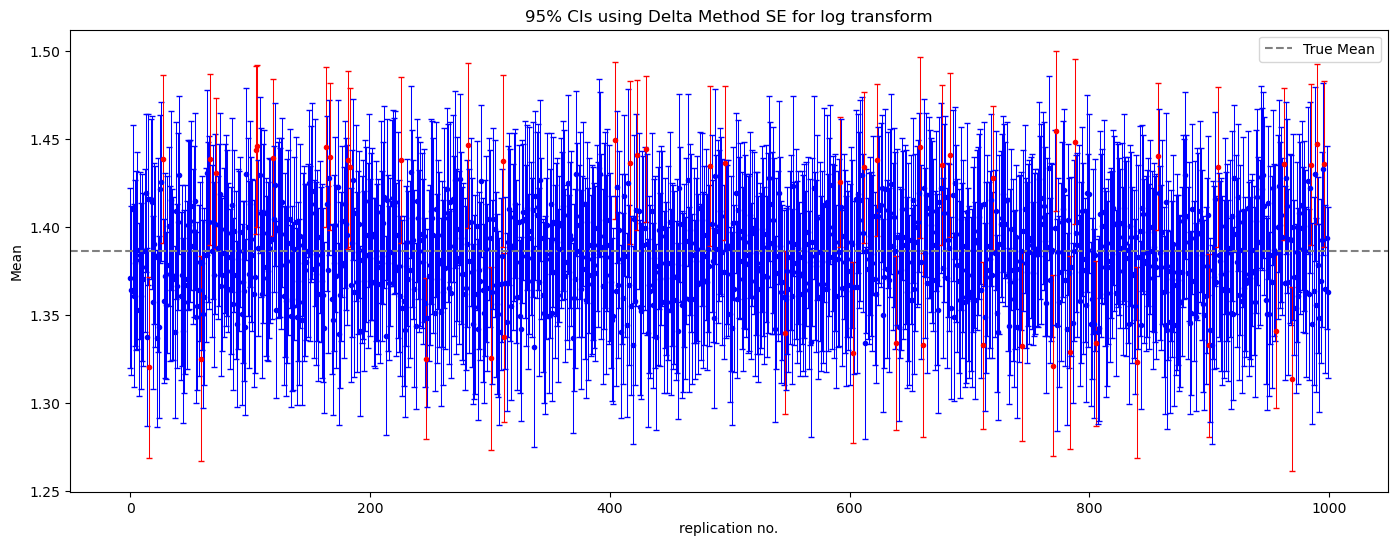

In [3]:
# log transformation
MU = 4
SIGMA = 1
N = 100
LOG_MU = np.log(MU)
coverages = np.zeros(NREP)
mu_txs = np.zeros(NREP)
ci_uppers = np.zeros(NREP)
ci_lowers = np.zeros(NREP)

for i in range(NREP):
  data = np.random.normal(MU, SIGMA, N)
  x_bar = np.mean(data)
  sigma_hat = np.std(data)
  mu_txs[i], sigma_tx = transform_data([x_bar], [sigma_hat], "log", "delta")
  ci_uppers[i] = mu_txs[i] + Q * sigma_tx / np.sqrt(N)
  ci_lowers[i] = mu_txs[i] - Q * sigma_tx / np.sqrt(N)
  if (ci_lowers[i] < LOG_MU and LOG_MU < ci_uppers[i]):
    coverages[i] = 1

coverage_pct = (coverages == 1).sum() / NREP
print("CI coverage rate: ", coverage_pct)

# plotting
plot_simulation(coverages, mu_txs, ci_lowers, ci_uppers, LOG_MU, "log transform")

# Bivariate Simulations

## Percentage Change
* the function that currently works as intended calculates percentage change in prevalence rates
  * note: prevalence is analogous to mean, just with binary data
* the function that simply calculates percentage change in counts does not currently work
  * in my experience, the RV is a function of consistent estimators, counts don't fall into that category
  * not completely certain that the above *must* be the case, perhaps just computing variance incorrectly?
  * tried both the formula in our overleaf and simply $np(1 - p)$ for variance

In [4]:
# parameters for population sizes and prevalence
Y1_POP, Y1_PREV = 1000, 0.03
Y2_POP, Y2_PREV = Y1_POP + 3000, (Y1_PREV + 0.28)

# simulate incidence from 2 years w/differing aforementioned parameters
y1_incid = np.random.binomial(Y1_POP, Y1_PREV, size=NREP)
y2_incid = np.random.binomial(Y2_POP, Y2_PREV, size=NREP)

# y1_incid = np.random.poisson(300, size=NREP)
# y2_incid = np.random.poisson(350, size=NREP)

# true difference in prevalence
TRUE_DIFF = (Y2_PREV / Y1_PREV) - 1
# TRUE_DIFF = (350 / 300) - 1
print("True percentage change in proportions: ", TRUE_DIFF)
print("10 replications of incidence counts in year 1: ", y1_incid[0:9])

True percentage change in proportions:  9.333333333333336
10 replications of incidence counts in year 1:  [34 33 37 30 28 34 22 21 40]


### Coverage

CI coverage rate:  0.949


/var/folders/55/53rfb8cd7bd3rvs9lvgv5zyw0000gn/T/ipykernel_11404/190171402.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mu_txs[i], sigma_hat = transform_percentage_change(y1_incid[i], Y1_POP, y2_incid[i], Y2_POP)
/var/folders/55/53rfb8cd7bd3rvs9lvgv5zyw0000gn/T/ipykernel_11404/190171402.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ci_uppers[i] = mu_txs[i] + Q * sigma_hat
/var/folders/55/53rfb8cd7bd3rvs9lvgv5zyw0000gn/T/ipykernel_11404/190171402.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performi

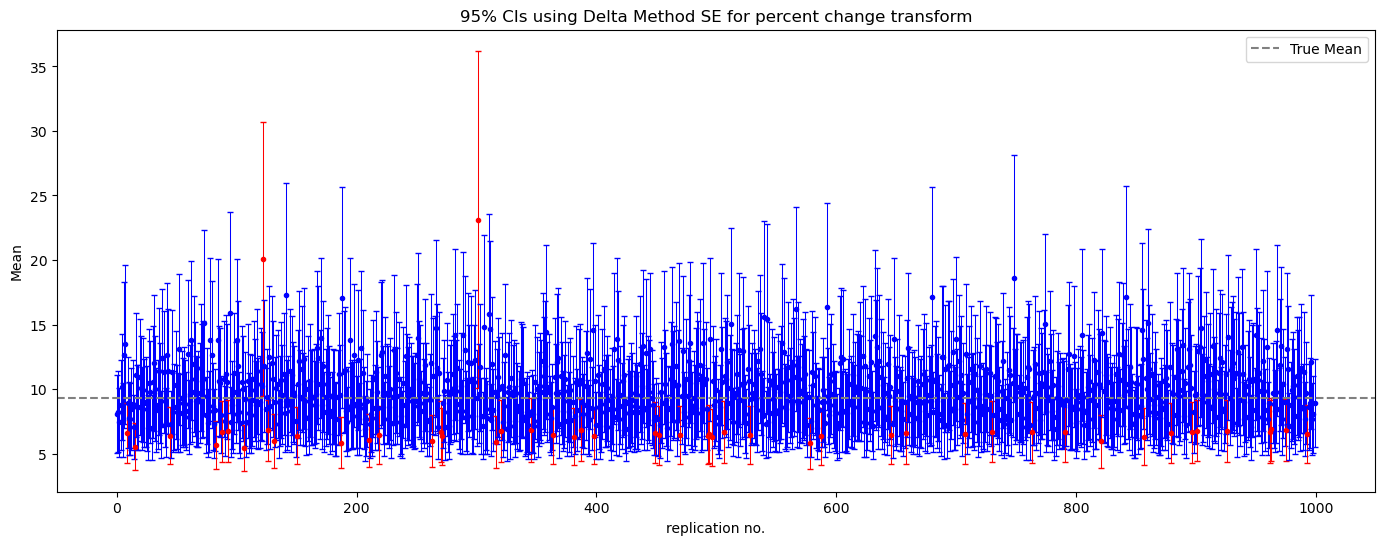

In [5]:
# TODO: document coverage with graphs in the tails
coverages, mu_txs, ci_uppers, ci_lowers = np.zeros(NREP), np.zeros(NREP), np.zeros(NREP), np.zeros(NREP)

# TODO: try to incorporate this into the testing suite
# print(np.var(y1_incid, ddof=1))
for i in range(NREP):
  mu_txs[i], sigma_hat = transform_percentage_change(y1_incid[i], Y1_POP, y2_incid[i], Y2_POP)
  ci_uppers[i] = mu_txs[i] + Q * sigma_hat
  ci_lowers[i] = mu_txs[i] - Q * sigma_hat
  if (ci_lowers[i] < TRUE_DIFF and TRUE_DIFF < ci_uppers[i]):
    coverages[i] = 1

coverage_pct = (coverages == 1).sum() / NREP
print("CI coverage rate: ", coverage_pct)

plot_simulation(coverages, mu_txs, ci_lowers, ci_uppers, TRUE_DIFF, "percent change transform")

It seems as though the CI length is wider than it should be at more extreme values of prevalence (i.e. those near 0 or 1). This is probably due to the fact that when computing the CI, the standard error was divided by the sample size of the first year. Unclear as to what it should be instead, any suggestions?

### Coverage over varying true prevalence

/var/folders/55/53rfb8cd7bd3rvs9lvgv5zyw0000gn/T/ipykernel_11404/813324598.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mu_txs[i], sigma_hat = transform_percentage_change(y1_incid[i], Y1_POP, y2_incid[i], Y2_POP)
/var/folders/55/53rfb8cd7bd3rvs9lvgv5zyw0000gn/T/ipykernel_11404/813324598.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ci_uppers[i] = mu_txs[i] + Q * sigma_hat
/var/folders/55/53rfb8cd7bd3rvs9lvgv5zyw0000gn/T/ipykernel_11404/813324598.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before perfo

[0.01 0.06 0.11 0.16 0.21 0.26 0.31 0.36 0.41 0.46 0.51 0.56 0.61 0.66
 0.71 0.76 0.81 0.86 0.91 0.96] [0.924, 0.942, 0.952, 0.946, 0.946, 0.955, 0.949, 0.953, 0.952, 0.955, 0.949, 0.945, 0.935, 0.944, 0.949, 0.956, 0.949, 0.949, 0.949, 0.954]


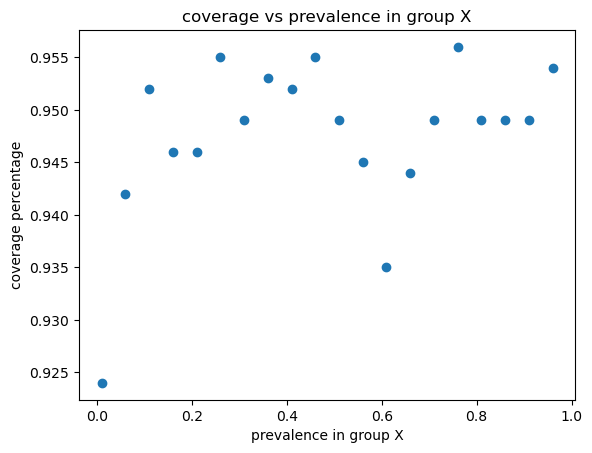

In [6]:
y1_prevalences = np.arange(0.01, 1, 0.05)
all_coverages = []

for y1_prev in y1_prevalences:
  coverages, mu_txs, ci_uppers, ci_lowers = np.zeros(NREP), np.zeros(NREP), np.zeros(NREP), np.zeros(NREP)
  Y1_POP, Y1_PREV = 1000, y1_prev
  Y2_POP, Y2_PREV = 1000, (Y1_PREV + 0.02)
  TRUE_DIFF = (Y2_PREV / Y1_PREV) - 1

  y1_incid = np.random.binomial(Y1_POP, Y1_PREV, size=NREP)
  y2_incid = np.random.binomial(Y2_POP, Y2_PREV, size=NREP)
  for i in range(NREP):
    mu_txs[i], sigma_hat = transform_percentage_change(y1_incid[i], Y1_POP, y2_incid[i], Y2_POP)
    ci_uppers[i] = mu_txs[i] + Q * sigma_hat
    ci_lowers[i] = mu_txs[i] - Q * sigma_hat
    if (ci_lowers[i] < TRUE_DIFF and TRUE_DIFF < ci_uppers[i]):
      coverages[i] = 1
  all_coverages.append((coverages == 1).sum() / NREP)

print(y1_prevalences, all_coverages)
plt.xlabel("prevalence in group X")
plt.ylabel("coverage percentage")
plt.title("coverage vs prevalence in group X")
plt.scatter(y1_prevalences, all_coverages)
plt.show()

### Coverage over varying true delta

[-0.09  0.01  0.11  0.21  0.31  0.41  0.51  0.61  0.71  0.81]


/var/folders/55/53rfb8cd7bd3rvs9lvgv5zyw0000gn/T/ipykernel_11404/3508961853.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mu_txs[i], sigma_hat = transform_percentage_change(y1_incid[i], Y1_POP, y2_incid[i], Y2_POP)
/var/folders/55/53rfb8cd7bd3rvs9lvgv5zyw0000gn/T/ipykernel_11404/3508961853.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ci_uppers[i] = mu_txs[i] + Q * sigma_hat
/var/folders/55/53rfb8cd7bd3rvs9lvgv5zyw0000gn/T/ipykernel_11404/3508961853.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before pe

[-0.9  0.1  1.1  2.1  3.1  4.1  5.1  6.1  7.1  8.1] [0.921, 0.945, 0.949, 0.953, 0.95, 0.941, 0.955, 0.946, 0.949, 0.951]


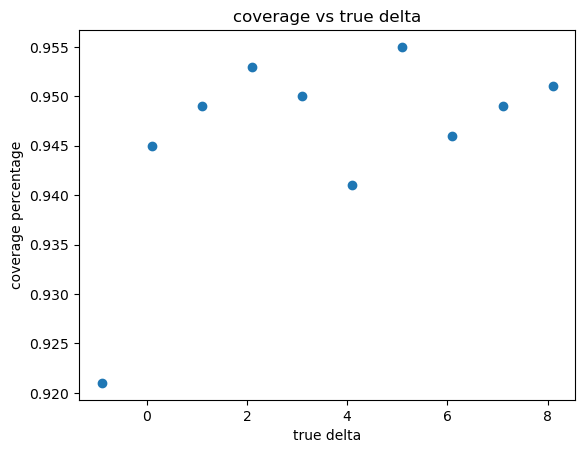

In [7]:
y2_prevalence_incs = np.arange(-0.09, 0.9, 0.1)
print(y2_prevalence_incs)
all_coverages = []

for y2_prev_inc in y2_prevalence_incs:
  coverages, mu_txs, ci_uppers, ci_lowers = np.zeros(NREP), np.zeros(NREP), np.zeros(NREP), np.zeros(NREP)
  Y1_POP, Y1_PREV = 1000, 0.1
  Y2_POP, Y2_PREV = 1000, (Y1_PREV + y2_prev_inc)
  TRUE_DIFF = (Y2_PREV / Y1_PREV) - 1

  y1_incid = np.random.binomial(Y1_POP, Y1_PREV, size=NREP)
  y2_incid = np.random.binomial(Y2_POP, Y2_PREV, size=NREP)
  for i in range(NREP):
    mu_txs[i], sigma_hat = transform_percentage_change(y1_incid[i], Y1_POP, y2_incid[i], Y2_POP)
    ci_uppers[i] = mu_txs[i] + Q * sigma_hat
    ci_lowers[i] = mu_txs[i] - Q * sigma_hat
    if (ci_lowers[i] < TRUE_DIFF and TRUE_DIFF < ci_uppers[i]):
      coverages[i] = 1
  all_coverages.append((coverages == 1).sum() / NREP)

print(((0.1 + y2_prevalence_incs) / 0.1) - 1, all_coverages)
plt.xlabel("true delta")
plt.ylabel("coverage percentage")
plt.title("coverage vs true delta")
plt.scatter(((0.1 + y2_prevalence_incs) / 0.1) - 1, all_coverages)
plt.show()

### Coverage over varying difference in sample size

/var/folders/55/53rfb8cd7bd3rvs9lvgv5zyw0000gn/T/ipykernel_11404/3515000061.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mu_txs[i], sigma_hat = transform_percentage_change(y1_incid[i], Y1_POP, y2_incid[i], Y2_POP)
/var/folders/55/53rfb8cd7bd3rvs9lvgv5zyw0000gn/T/ipykernel_11404/3515000061.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ci_uppers[i] = mu_txs[i] + Q * sigma_hat
/var/folders/55/53rfb8cd7bd3rvs9lvgv5zyw0000gn/T/ipykernel_11404/3515000061.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before pe

[0.948, 0.956, 0.938, 0.944, 0.946, 0.946, 0.95, 0.956, 0.957, 0.954, 0.94, 0.949, 0.956, 0.966, 0.955, 0.952, 0.943, 0.952, 0.95, 0.953, 0.962]


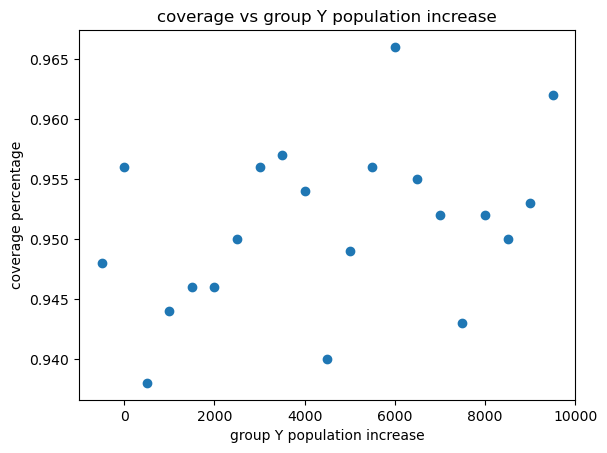

In [8]:
# perhaps plot on a log scale?
# is it better to scale by the larger population?
y2_population_incs = np.arange(-500, 10000, 500)
all_coverages = []

for y2_pop_inc in y2_population_incs:
  coverages, mu_txs, ci_uppers, ci_lowers = np.zeros(NREP), np.zeros(NREP), np.zeros(NREP), np.zeros(NREP)
  Y1_POP, Y1_PREV = 1000, 0.1
  Y2_POP, Y2_PREV = Y1_POP + y2_pop_inc, 0.3
  TRUE_DIFF = (Y2_PREV / Y1_PREV) - 1

  y1_incid = np.random.binomial(Y1_POP, Y1_PREV, size=NREP)
  y2_incid = np.random.binomial(Y2_POP, Y2_PREV, size=NREP)
  for i in range(NREP):
    mu_txs[i], sigma_hat = transform_percentage_change(y1_incid[i], Y1_POP, y2_incid[i], Y2_POP)
    ci_uppers[i] = mu_txs[i] + Q * sigma_hat
    ci_lowers[i] = mu_txs[i] - Q * sigma_hat
    if (ci_lowers[i] < TRUE_DIFF and TRUE_DIFF < ci_uppers[i]):
      coverages[i] = 1
  all_coverages.append((coverages == 1).sum() / NREP)

print(all_coverages)
plt.xlabel("group Y population increase")
plt.ylabel("coverage percentage")
plt.title("coverage vs group Y population increase")
plt.scatter(y2_population_incs, all_coverages)
plt.show()

### Verifying scale invariance
what does scale invariance mean?

In [9]:
# const = 3
# y1_incid = y1_incid
# y2_incid = y2_incid

# # TRUE_DIFF = (Y2_PREV / Y1_PREV) - 1

# coverages, mu_txs, ci_uppers, ci_lowers = np.zeros(NREP), np.zeros(NREP), np.zeros(NREP), np.zeros(NREP)

# for i in range(NREP):
#   mu_txs[i], sigma_hat = transform_percentage_change_counts1(y1_incid[i], Y1_POP, y2_incid[i], Y2_POP)
#   ci_uppers[i] = mu_txs[i] + Q * sigma_hat / np.sqrt(Y1_POP)
#   ci_lowers[i] = mu_txs[i] - Q * sigma_hat / np.sqrt(Y1_POP)
#   if (ci_lowers[i] < TRUE_DIFF and TRUE_DIFF < ci_uppers[i]):
#     coverages[i] = 1

# coverage_pct = (coverages == 1).sum() / NREP
# print("CI coverage rate: ", coverage_pct)

# plot_simulation(coverages, mu_txs, ci_lowers, ci_uppers, TRUE_DIFF, "percent change transform")

### Delta's distribution

TypeError: can only concatenate str (not "float") to str

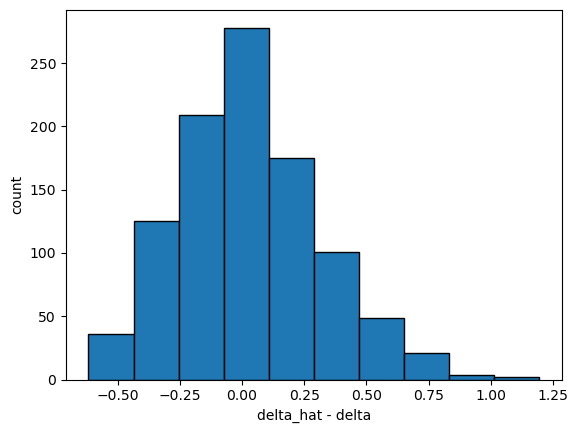

In [15]:
# maybe it's more interesting to plot the distribution of delta_hat - delta since that's what is normal by delta method/CLT
TRUE_DIFF = (Y2_PREV / Y1_PREV) - 1
y1_prevs = y1_incid / Y1_POP
y2_prevs = y2_incid / Y2_POP
plt.hist(((y2_prevs / y1_prevs) - 1) - TRUE_DIFF, bins=10, edgecolor="black")
plt.xlabel("delta_hat - delta")
plt.ylabel("count")
plt.title("histogram of centered delta_hat statistic, prevalences: (" + str(Y1_PREV) + ", " + str(Y2_PREV) + ")")
plt.show()

In [11]:
x_bar = 0.000693
s = 2.88e-7
temp = np.zeros(Y1_POP)
y1_rep1 = 10
temp[0:y1_rep1] = 1
tempvar = np.var(temp, ddof=1)
c_x = y1_rep1
n_x = Y1_POP
mu_x = c_x / n_x
sigma2_x = (c_x * (1 - mu_x) ** 2 + (n_x - c_x) * mu_x**2) / (n_x - 1)
print(tempvar, sigma2_x)

s = np.sqrt(0.00990990990990991)
x_bar = y1_rep1 / Y1_POP
print(s**2 / (s**2 - x_bar * (1 - x_bar) * ((1 - x_bar) + x_bar)), Y1_POP)

0.00990990990990991 0.009909909909909911
1000.0000000001432 1000
